In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
df = pd.read_csv('merged_flight_weather_data.csv')

In [14]:
df

,FL_DATE,AIRLINE,AIRLINE_DOT,AIRLINE_CODE,DOT_CODE,FL_NUMBER,ORIGIN,ORIGIN_CITY,DEST,DEST_CITY,...,dewpoint_f,will_it_rain,chance_of_rain,will_it_snow,chance_of_snow,vis_km,vis_miles,gust_mph,gust_kph,uv
0,2023-07-03,JetBlue Airways,JetBlue Airways: B6,B6,20409,431,BOS,"Boston, MA",LGA,"New York, NY",...,68.1,0,0,0,0,10.0,6,13.2,21.2,2.7
1,2020-02-26,JetBlue Airways,JetBlue Airways: B6,B6,20409,965,BOS,"Boston, MA",RSW,"Fort Myers, FL",...,43.0,0,0,0,0,8.3,5,18.8,30.2,0.0
2,2020-10-13,Southwest Airlines Co.,Southwest Airlines Co.: WN,WN,19393,1621,BOS,"Boston, MA",MDW,"Chicago, IL",...,51.8,1,100,0,0,7.0,4,22.6,36.4,0.0
3,2022-12-03,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,2600,BOS,"Boston, MA",DFW,"Dallas/Fort Worth, TX",...,45.6,0,0,0,0,10.0,6,28.6,46.0,0.0
4,2023-01-17,JetBlue Airways,JetBlue Airways: B6,B6,20409,781,BOS,"Boston, MA",RIC,"Richmond, VA",...,16.3,0,0,0,0,10.0,6,11.3,18.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55389,2021-10-01,Republic Airline,Republic Airline: YX,YX,20452,5632,BOS,"Boston, MA",JFK,"New York, NY",...,39.1,0,0,0,0,10.0,6,11.2,18.0,0.0
55390,2019-03-27,American Airlines Inc.,American Airlines Inc.: AA,AA,19805,688,BOS,"Boston, MA",PHL,"Philadelphia, PA",...,12.7,0,0,0,0,10.0,6,13.8,22.3,0.1
55391,2023-04-26,JetBlue Airways,JetBlue Airways: B6,B6,20409,2301,BOS,"Boston, MA",MSY,"New Orleans, LA",...,39.5,0,0,0,0,10.0,6,14.6,23.5,7.0
55392,2023-07-09,Republic Airline,Republic Airline: YX,YX,20452,4296,BOS,"Boston, MA",JFK,"New York, NY",...,68.5,0,0,0,0,10.0,6,14.0,22.5,1.3


In [15]:

# --- Data Cleaning ---
# Cancelled flights: force DEPTIME as NaN
if 'CANCELLED' in df and 'DEPTIME' in df:
    df.loc[df['CANCELLED'] == 1, 'DEPTIME'] = np.nan

# Fill missing values: numeric 0, text 'Null'
for c in df.columns:
    if pd.api.types.is_numeric_dtype(df[c]):
        df[c] = df[c].fillna(0)
    else:
        df[c] = df[c].fillna('Null')

# Quality: print missing counts
print(df.isnull().sum())

FL_DATE         0
AIRLINE         0
AIRLINE_DOT     0
AIRLINE_CODE    0
DOT_CODE        0
               ..
vis_km          0
vis_miles       0
gust_mph        0
gust_kph        0
uv              0
Length: 70, dtype: int64


In [16]:
# --- Feature Engineering ---
# Round flight time to nearest hour for grouping
if 'DEPTIME' in df and not df['DEPTIME'].isnull().all():
    df['DEPHOUR'] = (df['DEPTIME'] // 100 + (df['DEPTIME'] % 100 >= 30)).astype('Int64')
else:
    df['DEPHOUR'] = pd.NA

# --- Plots: Weather vs Delay ---
plot_vars = ['windmph', 'precipmm', 'humidity', 'viskm', 'winddegree']
for var in plot_vars:
    if var in df.columns:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=var, y='DEP_DELAY', data=df)
        plt.title(f'{var} vs Departure Delay')
        plt.tight_layout()
        plt.savefig(f'{var}_vs_delay.png')
        plt.close()

# Histogram: Departure delay
plt.figure(figsize=(8, 5))
sns.histplot(df['DEP_DELAY'], bins=30)
plt.title('Distribution of Departure Delay (min)')
plt.tight_layout()
plt.savefig('delay_histogram.png')
plt.close()

# Boxplot: By hour and by airline
plt.figure(figsize=(12, 6))
sns.boxplot(x='DEP_HOUR', y='DEP_DELAY', data=df)
plt.title('Delay by Departure Hour')
plt.tight_layout()
plt.savefig('box_by_hour.png')
plt.close()


In [17]:
if 'AIRLINE' in df.columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='AIRLINE', y='DEP_DELAY', data=df)
    plt.title('Departure Delay by Airline')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('box_by_airline.png')
    plt.close()

# --- On-time Classification ---
df['ONTIME'] = np.where(df['DEP_DELAY'] <= 15, 1, 0)
plt.figure(figsize=(6,4))
sns.countplot(x='ONTIME', data=df)
plt.title('On-Time vs Delayed')
plt.tight_layout()
plt.savefig('on_time_vs_delayed.png')
plt.close()


In [ ]:
# --- Modeling: Regression + Classification ---
# Choosing numerical predictors
predictors = [
    'DEPHOUR',
    'DISTANCE',
    'tempc', 'tempf',
    'windmph', 'windkph',
    'humidity',
    'viskm', 'vismiles',
    'precipmm',
    'timeepoch'
]
predictors = [p for p in predictors if p in df.columns]

# One-hot encode airline
df_feats = df.copy()
if 'AIRLINE' in df_feats.columns:
    df_feats = pd.get_dummies(df_feats, columns=['AIRLINE'], drop_first=True)

# Build X from selected predictors + airline dummies
X_cols = predictors + [c for c in df_feats.columns if c.startswith('AIRLINE_')]
X = df_feats[X_cols]

# Keep only numeric columns (avoid datetimes/strings)
X = X.select_dtypes(include=['int64', 'float64'])

y_reg = df_feats['DEP_DELAY']
y_clf = df_feats['ONTIME']

print("Feature dtypes in X:")
print(X.dtypes.value_counts())

# Train-test split (Regression)
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# --- Regression Models ---
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

reg_results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    reg_results.append([
        name,
        r2_score(y_test, y_pred),
        np.sqrt(mean_squared_error(y_test, y_pred)),
        mean_absolute_error(y_test, y_pred)
    ])

reg_results_df = pd.DataFrame(reg_results, columns=['Model', 'R2', 'RMSE', 'MAE'])
print("\nRegression results:")
print(reg_results_df)

# --- K-fold CV (Linear Regression) ---
kf = KFold(5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LinearRegression(), X, y_reg, cv=kf, scoring='neg_mean_squared_error')
print("\n5-fold CV RMSE (LinearRegression):", np.sqrt(-cv_scores).mean())

# --- Optional: PCA on scaled features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  # keep 95% variance
X_pca = pca.fit_transform(X_scaled)

Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y_reg, test_size=0.2, random_state=42)
lr_pca = LinearRegression()
lr_pca.fit(Xp_train, yp_train)
yp_pred = lr_pca.predict(Xp_test)
print("Linear Regression with PCA RMSE:",
      np.sqrt(mean_squared_error(yp_test, yp_pred)))

# --- Classification (LogReg, SVM, KNN) ---
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X, y_clf, test_size=0.2, random_state=42)

clfs = {
    'LogisticRegression': LogisticRegression(max_iter=300),
    'SVM': SVC(),
    'KNN': KNeighborsClassifier()
}

clf_results = []
for name, clf in clfs.items():
    clf.fit(Xc_train, yc_train)
    y_pred = clf.predict(Xc_test)
    clf_results.append([
        name,
        accuracy_score(yc_test, y_pred),
        precision_score(yc_test, y_pred),
        recall_score(yc_test, y_pred),
        f1_score(yc_test, y_pred)
    ])

clf_results_df = pd.DataFrame(clf_results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1'])
print("\nClassification results:")
print(clf_results_df)

# --- Feature importance (Linear Regression coefficients) ---
lr = LinearRegression().fit(X_train, y_train)
imp_features = pd.Series(lr.coef_, index=X.columns).abs().sort_values(ascending=False)
print("\nTop features by absolute LR coefficient:")
print(imp_features.head(20))

Feature dtypes in X:
float64    1
int64      1
Name: count, dtype: int64

Regression results:
              Model        R2       RMSE        MAE
0  LinearRegression  0.007359  45.910550  23.224190
1             Ridge  0.007359  45.910550  23.224190
2             Lasso  0.007319  45.911487  23.224991
3        ElasticNet  0.007336  45.911084  23.224648
4      RandomForest -0.083464  47.964906  24.030615
5  GradientBoosting  0.011544  45.813662  23.043852

5-fold CV RMSE (LinearRegression): 48.27798702346981
Linear Regression with PCA RMSE: 45.910549599003076

Classification results:
           Classifier  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.823450   0.823450  1.000000  0.903178
1                 SVM  0.823450   0.823450  1.000000  0.903178
2                 KNN  0.792851   0.823602  0.952428  0.883343

Top features by absolute LR coefficient:
humidity    0.158234
DISTANCE    0.000751
dtype: float64


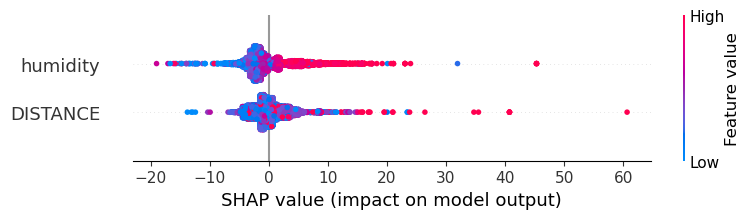

In [21]:
import shap

# Train a strong tree-based regressor (if not already trained)
gb_best = GradientBoostingRegressor(n_estimators=300, random_state=42)
gb_best.fit(X_train, y_train)

# SHAP explainer for tree models
explainer = shap.TreeExplainer(gb_best)
shap_values = explainer.shap_values(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test, max_display=15)


In [23]:
# Time-aware split using FL_DATE
df_sorted = df.sort_values('FL_DATE')  # FL_DATE exists in your CSV [attached_file:4]

X_sorted = X.loc[df_sorted.index]
y_sorted = y_reg.loc[df_sorted.index]

split_idx = int(len(X_sorted) * 0.8)
X_train_t, X_test_t = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
y_train_t, y_test_t = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

gb_time = GradientBoostingRegressor(n_estimators=300, random_state=42)
gb_time.fit(X_train_t, y_train_t)
y_pred_t = gb_time.predict(X_test_t)

print("Time-based R2:", r2_score(y_test_t, y_pred_t))
print("Time-based RMSE:", np.sqrt(mean_squared_error(y_test_t, y_pred_t)))
print("Time-based MAE:", mean_absolute_error(y_test_t, y_pred_t))


Time-based R2: -0.0108893604674829
Time-based RMSE: 62.55202661059494
Time-based MAE: 26.392084932940048


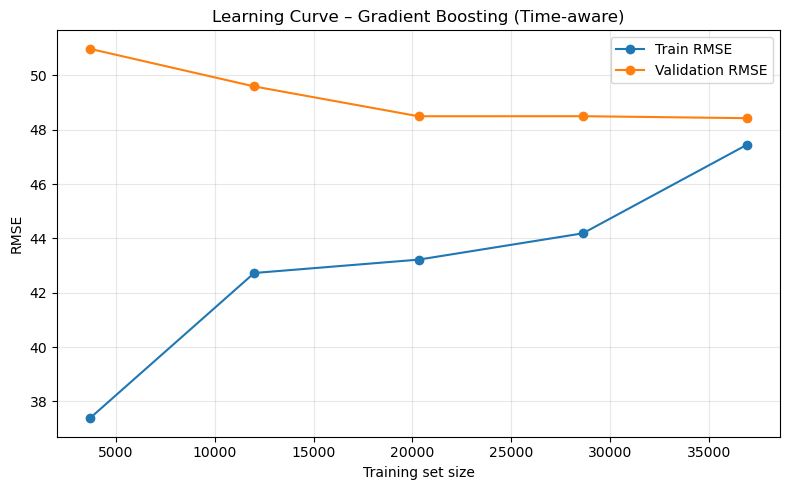

In [26]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    gb_time,
    X_sorted,
    y_sorted,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring='neg_root_mean_squared_error',
    shuffle=False
)

train_rmse = -train_scores.mean(axis=1)
val_rmse = -val_scores.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, marker='o', label='Train RMSE')
plt.plot(train_sizes, val_rmse, marker='o', label='Validation RMSE')
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.title('Learning Curve – Gradient Boosting (Time-aware)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
